In [15]:
K = NumberField(x-1,'z') #need to construct this number field isomorphic to QQ, as working directly over QQ gives errors
OK = K.ideal(1) #this is isomorphic to ZZ
#Added bonus of this workaround is that we can use the following definitions for different fields

In [13]:
def DenominatorSize(q, afrak):
    '''
    INPUT: q rational number -> a/b, afrak fractional ideal in QQ
    OUTPUT: denominator size N(b)/N(cfrak), where cfrak = (a) + b*afrak^(-1)
    '''
    if q not in QQ:
        raise ValueError("first input should be a rational number")
    a = q.numerator()
    b = q.denominator()
    cfrak = a*OK + b*afrak^(-1)
    D = abs(b)/cfrak.norm()
    return D

In [26]:
def newFareySum(q1, q2, afrak):
    '''
    INPUT: q1, q2 rational numbers, afrak fractional ideal in QQ
    OUTPUT: Farey sum (n1+n2)/(d1+d2) rational number
    '''
    if q1 not in QQ or q2 not in QQ:
        raise ValueError("first two inputs should be two rational numbers")
    D1 = DenominatorSize(q1,afrak)
    D2 = DenominatorSize(q2,afrak)
    sum = (D1*q1+D2*q2)/(D1+D2)
    return sum

In [24]:
def newFareyVertices(L, afrak, seq = False):
    '''
    INPUT: L non-negative integer, afrak fractional ideal of QQ, a Boolean that is False by default
    OUTPUT: dictionary of vertices in the Farey sequence of level L with a list of their two neighbours, if seq == True also the list of vertices, which is the Farey sequence of level L
    '''
    if L not in ZZ or L < 0:
        raise ValueError("input should be a non-negative integer")
    sequence = [0, 1] #list of rationals of the Farey sequence
    vertices = {0: (), 1: ()} #dictionary: keys are rationals in the Farey sequence, for each key we have a tuple of the (at most two) neighbouring rationals
    for i in range(L): #we iterate on the level to build the sequence
        length = len(sequence) - 1
        sequencesums = [newFareySum(sequence[j], sequence[j+1], afrak) for j in range(length)] #this is a list of the Farey sums of consecutive entries of the sequence
        for j in range(length):
            vertices[sequencesums[j]] = sequence[j], sequence[j+1] #each new Farey number found in 'sequencesums' is a new key in the dictionary 'vertices', and to it we associate its two neighbours found in 'sequence'
        newsequence = []
        for k in range(length): #this for loop creates a sequence alternating entries from the previous level with entries from 'sequencesums'
            newsequence.append(sequence[k])
            newsequence.append(sequencesums[k])
        newsequence.append(1)
        sequence = newsequence
    if seq == True:
        return vertices, sequence
    return vertices

In [35]:
def newFareyTree(L, afrak):
    '''
    INPUT: L non-negative integer, afrak a fractional ideal in QQ
    OUTPUT: graph of the Farey sequence of level L
    '''
    if L not in ZZ or L < 0:
        raise ValueError("input should be a non-negative integer")
    coordinates = [(0,0), (1,0)] #this will be the list of all the points (q, (L-1-level of q)/(L-1)) for q rational number in Farey sequence
    lines = line([(0,0),(0,1)], linestyle = '--') + line([(1,0),(1,1)], linestyle = '--') #this gives vertical dashed lines at 0 and 1, we will add lines between points to this
    if L == 0:
        return plot(lines)
    if L == 1: #case treated separately to avoid division by 0 in general case
        return plot(lines + point((1/2,1), marker = 'o'))
    if L > 1:
        vertices = newFareyVertices(L, afrak)
        rationals = [*vertices] #we take keys of the dictionary FareyVertices(L) as a list, so we get all the rational numbers in the Farey sequence of level L ordered according to the level they appeared at
        for i in range(L):
            coordinates.extend([(q,(L-1-i)/(L-1)) for q in rationals[1+2^i:1+2^(i+1)]]) #coordinates 
        for p in coordinates[-1:2:-1]: #we draw lines starting from the bottom
            if DenominatorSize(vertices[p[0]][0], afrak) > DenominatorSize(vertices[p[0]][1], afrak): #this if checks which neighbour is connected to the point we are considering: it's always that with bigger denominator
                proot = vertices[p[0]][0]
            else:
                proot = vertices[p[0]][1]
            lines = lines + line([p,(proot,p[1]+1/(L-1))])
        return plot(lines)

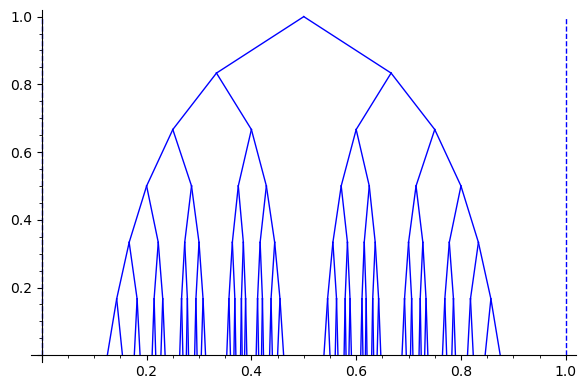

In [38]:
newFareyTree(7,OK)